## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 200
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

## Calculate mean and std

In [4]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
])

path = 'CV_data/dataset_augmented'
dataset = datasets.ImageFolder(root=path, transform=transform)

# Define the subset size
subset_size = 1000

# Create a SubsetRandomSampler to sample from the dataset
sampler = torch.utils.data.SubsetRandomSampler(range(subset_size))

# Create a DataLoader with the specified sampler
loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), sampler=sampler)
# Calculate the mean and std
data = next(iter(loader))
mean = data[0].mean()
std = data[0].std()

print("Mean:", mean)
print("Std:", std)

Mean: tensor(0.5014)
Std: tensor(0.3438)


In [5]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = datasets.ImageFolder(root=path, transform=transform)

# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


In [7]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 200, 200])
Image label dimensions: torch.Size([32])
Labels: tensor([11, 11, 12, 23, 35, 21,  3, 54, 22, 59,  4, 53, 25, 40,  7, 64, 40, 44,
        58, 32, 39, 54, 11, 32, 36, 59, 48, 59, 38, 55, 33, 11])


In [8]:
from collections import Counter


train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005])

In [9]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


In [10]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [11]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [12]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [13]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

In [14]:
model_name = "09-model"

## Training

In [15]:

start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/4332 | Cost: 4.3497
Epoch: 001/020 | Batch 0050/4332 | Cost: 4.0225
Epoch: 001/020 | Batch 0100/4332 | Cost: 3.9118
Epoch: 001/020 | Batch 0150/4332 | Cost: 3.5981
Epoch: 001/020 | Batch 0200/4332 | Cost: 3.7355
Epoch: 001/020 | Batch 0250/4332 | Cost: 3.1103
Epoch: 001/020 | Batch 0300/4332 | Cost: 3.1683
Epoch: 001/020 | Batch 0350/4332 | Cost: 3.0549
Epoch: 001/020 | Batch 0400/4332 | Cost: 3.0283
Epoch: 001/020 | Batch 0450/4332 | Cost: 2.4644
Epoch: 001/020 | Batch 0500/4332 | Cost: 2.5072
Epoch: 001/020 | Batch 0550/4332 | Cost: 2.5277
Epoch: 001/020 | Batch 0600/4332 | Cost: 2.6344
Epoch: 001/020 | Batch 0650/4332 | Cost: 2.5039
Epoch: 001/020 | Batch 0700/4332 | Cost: 2.2782
Epoch: 001/020 | Batch 0750/4332 | Cost: 2.2338
Epoch: 001/020 | Batch 0800/4332 | Cost: 2.2580
Epoch: 001/020 | Batch 0850/4332 | Cost: 2.2631
Epoch: 001/020 | Batch 0900/4332 | Cost: 2.2105
Epoch: 001/020 | Batch 0950/4332 | Cost: 2.4365
Epoch: 001/020 | Batch 1000/4332 | Cost:

4332it [06:57, 10.37it/s]
1444it [02:22, 10.14it/s]
1444it [02:18, 10.44it/s]


Time elapsed: 19.84 min
Epoch: 002/020 | Batch 0000/4332 | Cost: 1.1026
Epoch: 002/020 | Batch 0050/4332 | Cost: 0.7983
Epoch: 002/020 | Batch 0100/4332 | Cost: 0.5359
Epoch: 002/020 | Batch 0150/4332 | Cost: 1.1790
Epoch: 002/020 | Batch 0200/4332 | Cost: 0.7640
Epoch: 002/020 | Batch 0250/4332 | Cost: 0.9914
Epoch: 002/020 | Batch 0300/4332 | Cost: 1.0236
Epoch: 002/020 | Batch 0350/4332 | Cost: 0.7082
Epoch: 002/020 | Batch 0400/4332 | Cost: 0.9491
Epoch: 002/020 | Batch 0450/4332 | Cost: 0.8657
Epoch: 002/020 | Batch 0500/4332 | Cost: 0.8700
Epoch: 002/020 | Batch 0550/4332 | Cost: 1.0691
Epoch: 002/020 | Batch 0600/4332 | Cost: 1.0101
Epoch: 002/020 | Batch 0650/4332 | Cost: 1.0239
Epoch: 002/020 | Batch 0700/4332 | Cost: 0.7819
Epoch: 002/020 | Batch 0750/4332 | Cost: 0.7121
Epoch: 002/020 | Batch 0800/4332 | Cost: 0.9735
Epoch: 002/020 | Batch 0850/4332 | Cost: 0.5331
Epoch: 002/020 | Batch 0900/4332 | Cost: 0.7911
Epoch: 002/020 | Batch 0950/4332 | Cost: 0.7232
Epoch: 002/020 |

4332it [06:57, 10.38it/s]
1444it [02:19, 10.33it/s]
1444it [02:23, 10.08it/s]


Time elapsed: 39.65 min
Epoch: 003/020 | Batch 0000/4332 | Cost: 0.6843
Epoch: 003/020 | Batch 0050/4332 | Cost: 0.5809
Epoch: 003/020 | Batch 0100/4332 | Cost: 0.6670
Epoch: 003/020 | Batch 0150/4332 | Cost: 0.5285
Epoch: 003/020 | Batch 0200/4332 | Cost: 0.4505
Epoch: 003/020 | Batch 0250/4332 | Cost: 0.2573
Epoch: 003/020 | Batch 0300/4332 | Cost: 0.5012
Epoch: 003/020 | Batch 0350/4332 | Cost: 1.2164
Epoch: 003/020 | Batch 0400/4332 | Cost: 0.4752
Epoch: 003/020 | Batch 0450/4332 | Cost: 0.3392
Epoch: 003/020 | Batch 0500/4332 | Cost: 0.5764
Epoch: 003/020 | Batch 0550/4332 | Cost: 0.8306
Epoch: 003/020 | Batch 0600/4332 | Cost: 1.6747
Epoch: 003/020 | Batch 0650/4332 | Cost: 0.4733
Epoch: 003/020 | Batch 0700/4332 | Cost: 0.5566
Epoch: 003/020 | Batch 0750/4332 | Cost: 0.6618
Epoch: 003/020 | Batch 0800/4332 | Cost: 0.4638
Epoch: 003/020 | Batch 0850/4332 | Cost: 0.5862
Epoch: 003/020 | Batch 0900/4332 | Cost: 0.1698
Epoch: 003/020 | Batch 0950/4332 | Cost: 0.5374
Epoch: 003/020 |

4332it [07:06, 10.16it/s]
1444it [02:21, 10.19it/s]
1444it [02:20, 10.25it/s]


Time elapsed: 59.72 min
Epoch: 004/020 | Batch 0000/4332 | Cost: 0.4591
Epoch: 004/020 | Batch 0050/4332 | Cost: 0.2332
Epoch: 004/020 | Batch 0100/4332 | Cost: 0.3992
Epoch: 004/020 | Batch 0150/4332 | Cost: 0.3605
Epoch: 004/020 | Batch 0200/4332 | Cost: 0.4017
Epoch: 004/020 | Batch 0250/4332 | Cost: 0.5600
Epoch: 004/020 | Batch 0300/4332 | Cost: 0.5079
Epoch: 004/020 | Batch 0350/4332 | Cost: 0.6343
Epoch: 004/020 | Batch 0400/4332 | Cost: 0.2012
Epoch: 004/020 | Batch 0450/4332 | Cost: 0.3908
Epoch: 004/020 | Batch 0500/4332 | Cost: 0.6977
Epoch: 004/020 | Batch 0550/4332 | Cost: 0.3864
Epoch: 004/020 | Batch 0600/4332 | Cost: 0.2749
Epoch: 004/020 | Batch 0650/4332 | Cost: 0.3872
Epoch: 004/020 | Batch 0700/4332 | Cost: 0.3135
Epoch: 004/020 | Batch 0750/4332 | Cost: 0.4549
Epoch: 004/020 | Batch 0800/4332 | Cost: 0.6835
Epoch: 004/020 | Batch 0850/4332 | Cost: 0.2997
Epoch: 004/020 | Batch 0900/4332 | Cost: 0.5845
Epoch: 004/020 | Batch 0950/4332 | Cost: 0.7043
Epoch: 004/020 |

4332it [07:12, 10.01it/s]
1444it [02:27,  9.78it/s]
1444it [02:22, 10.10it/s]


Time elapsed: 80.02 min
Epoch: 005/020 | Batch 0000/4332 | Cost: 0.4044
Epoch: 005/020 | Batch 0050/4332 | Cost: 0.2995
Epoch: 005/020 | Batch 0100/4332 | Cost: 0.2548
Epoch: 005/020 | Batch 0150/4332 | Cost: 0.3943
Epoch: 005/020 | Batch 0200/4332 | Cost: 0.2756
Epoch: 005/020 | Batch 0250/4332 | Cost: 0.2941
Epoch: 005/020 | Batch 0300/4332 | Cost: 0.2016
Epoch: 005/020 | Batch 0350/4332 | Cost: 0.2652
Epoch: 005/020 | Batch 0400/4332 | Cost: 0.2762
Epoch: 005/020 | Batch 0450/4332 | Cost: 0.1533
Epoch: 005/020 | Batch 0500/4332 | Cost: 0.3261
Epoch: 005/020 | Batch 0550/4332 | Cost: 0.6218
Epoch: 005/020 | Batch 0600/4332 | Cost: 0.3284
Epoch: 005/020 | Batch 0650/4332 | Cost: 0.4715
Epoch: 005/020 | Batch 0700/4332 | Cost: 0.1015
Epoch: 005/020 | Batch 0750/4332 | Cost: 0.1997
Epoch: 005/020 | Batch 0800/4332 | Cost: 0.2198
Epoch: 005/020 | Batch 0850/4332 | Cost: 0.2012
Epoch: 005/020 | Batch 0900/4332 | Cost: 0.2692
Epoch: 005/020 | Batch 0950/4332 | Cost: 0.3035
Epoch: 005/020 |

4332it [07:16,  9.92it/s]
1444it [02:23, 10.06it/s]
1444it [02:21, 10.18it/s]


Time elapsed: 100.44 min
Epoch: 006/020 | Batch 0000/4332 | Cost: 0.4439
Epoch: 006/020 | Batch 0050/4332 | Cost: 0.2183
Epoch: 006/020 | Batch 0100/4332 | Cost: 0.4592
Epoch: 006/020 | Batch 0150/4332 | Cost: 0.3239
Epoch: 006/020 | Batch 0200/4332 | Cost: 0.1463
Epoch: 006/020 | Batch 0250/4332 | Cost: 0.6078
Epoch: 006/020 | Batch 0300/4332 | Cost: 0.1143
Epoch: 006/020 | Batch 0350/4332 | Cost: 0.2909
Epoch: 006/020 | Batch 0400/4332 | Cost: 0.4061
Epoch: 006/020 | Batch 0450/4332 | Cost: 0.3456
Epoch: 006/020 | Batch 0500/4332 | Cost: 0.1165
Epoch: 006/020 | Batch 0550/4332 | Cost: 0.5034
Epoch: 006/020 | Batch 0600/4332 | Cost: 0.2389
Epoch: 006/020 | Batch 0650/4332 | Cost: 0.1396
Epoch: 006/020 | Batch 0700/4332 | Cost: 0.4984
Epoch: 006/020 | Batch 0750/4332 | Cost: 0.4818
Epoch: 006/020 | Batch 0800/4332 | Cost: 0.4334
Epoch: 006/020 | Batch 0850/4332 | Cost: 0.1453
Epoch: 006/020 | Batch 0900/4332 | Cost: 0.1596
Epoch: 006/020 | Batch 0950/4332 | Cost: 0.1832
Epoch: 006/020 

4332it [06:59, 10.32it/s]
1444it [02:22, 10.15it/s]
1444it [02:19, 10.34it/s]


Time elapsed: 120.32 min
Epoch: 007/020 | Batch 0000/4332 | Cost: 0.3532
Epoch: 007/020 | Batch 0050/4332 | Cost: 0.1964
Epoch: 007/020 | Batch 0100/4332 | Cost: 0.2149
Epoch: 007/020 | Batch 0150/4332 | Cost: 0.1095
Epoch: 007/020 | Batch 0200/4332 | Cost: 0.3065
Epoch: 007/020 | Batch 0250/4332 | Cost: 0.1396
Epoch: 007/020 | Batch 0300/4332 | Cost: 0.2062
Epoch: 007/020 | Batch 0350/4332 | Cost: 0.3342
Epoch: 007/020 | Batch 0400/4332 | Cost: 0.3146
Epoch: 007/020 | Batch 0450/4332 | Cost: 0.4284
Epoch: 007/020 | Batch 0500/4332 | Cost: 0.0994
Epoch: 007/020 | Batch 0550/4332 | Cost: 0.2673
Epoch: 007/020 | Batch 0600/4332 | Cost: 0.3233
Epoch: 007/020 | Batch 0650/4332 | Cost: 0.1433
Epoch: 007/020 | Batch 0700/4332 | Cost: 0.3146
Epoch: 007/020 | Batch 0750/4332 | Cost: 0.2912
Epoch: 007/020 | Batch 0800/4332 | Cost: 0.1291
Epoch: 007/020 | Batch 0850/4332 | Cost: 0.4113
Epoch: 007/020 | Batch 0900/4332 | Cost: 0.3033
Epoch: 007/020 | Batch 0950/4332 | Cost: 0.2612
Epoch: 007/020 

4332it [07:04, 10.22it/s]
1444it [02:24,  9.99it/s]
1444it [02:20, 10.27it/s]


Time elapsed: 140.37 min
Epoch: 008/020 | Batch 0000/4332 | Cost: 0.1182
Epoch: 008/020 | Batch 0050/4332 | Cost: 0.1881
Epoch: 008/020 | Batch 0100/4332 | Cost: 0.2594
Epoch: 008/020 | Batch 0150/4332 | Cost: 0.0364
Epoch: 008/020 | Batch 0200/4332 | Cost: 0.1010
Epoch: 008/020 | Batch 0250/4332 | Cost: 0.1385
Epoch: 008/020 | Batch 0300/4332 | Cost: 0.2001
Epoch: 008/020 | Batch 0350/4332 | Cost: 0.3139
Epoch: 008/020 | Batch 0400/4332 | Cost: 0.2638
Epoch: 008/020 | Batch 0450/4332 | Cost: 0.2699
Epoch: 008/020 | Batch 0500/4332 | Cost: 0.2723
Epoch: 008/020 | Batch 0550/4332 | Cost: 0.2307
Epoch: 008/020 | Batch 0600/4332 | Cost: 0.4830
Epoch: 008/020 | Batch 0650/4332 | Cost: 0.3084
Epoch: 008/020 | Batch 0700/4332 | Cost: 0.0665
Epoch: 008/020 | Batch 0750/4332 | Cost: 0.4067
Epoch: 008/020 | Batch 0800/4332 | Cost: 0.0379
Epoch: 008/020 | Batch 0850/4332 | Cost: 0.0691
Epoch: 008/020 | Batch 0900/4332 | Cost: 0.2174
Epoch: 008/020 | Batch 0950/4332 | Cost: 0.1788
Epoch: 008/020 

4332it [07:02, 10.26it/s]
1444it [02:19, 10.34it/s]
1444it [02:20, 10.28it/s]


Time elapsed: 160.27 min
Epoch: 009/020 | Batch 0000/4332 | Cost: 0.1707
Epoch: 009/020 | Batch 0050/4332 | Cost: 0.1377
Epoch: 009/020 | Batch 0100/4332 | Cost: 0.1437
Epoch: 009/020 | Batch 0150/4332 | Cost: 0.1381
Epoch: 009/020 | Batch 0200/4332 | Cost: 0.3065
Epoch: 009/020 | Batch 0250/4332 | Cost: 0.1325
Epoch: 009/020 | Batch 0300/4332 | Cost: 0.1612
Epoch: 009/020 | Batch 0350/4332 | Cost: 0.2484
Epoch: 009/020 | Batch 0400/4332 | Cost: 0.1345
Epoch: 009/020 | Batch 0450/4332 | Cost: 0.0321
Epoch: 009/020 | Batch 0500/4332 | Cost: 0.0896
Epoch: 009/020 | Batch 0550/4332 | Cost: 0.1238
Epoch: 009/020 | Batch 0600/4332 | Cost: 0.0407
Epoch: 009/020 | Batch 0650/4332 | Cost: 0.0752
Epoch: 009/020 | Batch 0700/4332 | Cost: 0.0896
Epoch: 009/020 | Batch 0750/4332 | Cost: 0.3540
Epoch: 009/020 | Batch 0800/4332 | Cost: 0.1879
Epoch: 009/020 | Batch 0850/4332 | Cost: 0.0803
Epoch: 009/020 | Batch 0900/4332 | Cost: 0.0686
Epoch: 009/020 | Batch 0950/4332 | Cost: 0.1519
Epoch: 009/020 

4332it [07:11, 10.04it/s]
1444it [02:21, 10.24it/s]
1444it [02:21, 10.19it/s]


Time elapsed: 180.32 min
Epoch: 010/020 | Batch 0000/4332 | Cost: 0.0661
Epoch: 010/020 | Batch 0050/4332 | Cost: 0.1571
Epoch: 010/020 | Batch 0100/4332 | Cost: 0.2592
Epoch: 010/020 | Batch 0150/4332 | Cost: 0.1038
Epoch: 010/020 | Batch 0200/4332 | Cost: 0.0961
Epoch: 010/020 | Batch 0250/4332 | Cost: 0.1961
Epoch: 010/020 | Batch 0300/4332 | Cost: 0.0249
Epoch: 010/020 | Batch 0350/4332 | Cost: 0.1772
Epoch: 010/020 | Batch 0400/4332 | Cost: 0.1557
Epoch: 010/020 | Batch 0450/4332 | Cost: 0.2462
Epoch: 010/020 | Batch 0500/4332 | Cost: 0.1229
Epoch: 010/020 | Batch 0550/4332 | Cost: 0.1219
Epoch: 010/020 | Batch 0600/4332 | Cost: 0.3298
Epoch: 010/020 | Batch 0650/4332 | Cost: 0.0859
Epoch: 010/020 | Batch 0700/4332 | Cost: 0.2221
Epoch: 010/020 | Batch 0750/4332 | Cost: 0.0883
Epoch: 010/020 | Batch 0800/4332 | Cost: 0.1620
Epoch: 010/020 | Batch 0850/4332 | Cost: 0.2326
Epoch: 010/020 | Batch 0900/4332 | Cost: 0.0450
Epoch: 010/020 | Batch 0950/4332 | Cost: 0.1494
Epoch: 010/020 

4332it [07:12, 10.02it/s]
1444it [02:27,  9.80it/s]
1444it [02:24, 10.00it/s]


Time elapsed: 200.65 min
Epoch: 011/020 | Batch 0000/4332 | Cost: 0.0506
Epoch: 011/020 | Batch 0050/4332 | Cost: 0.0939
Epoch: 011/020 | Batch 0100/4332 | Cost: 0.0590
Epoch: 011/020 | Batch 0150/4332 | Cost: 0.2366
Epoch: 011/020 | Batch 0200/4332 | Cost: 0.1207
Epoch: 011/020 | Batch 0250/4332 | Cost: 0.1145
Epoch: 011/020 | Batch 0300/4332 | Cost: 0.2485
Epoch: 011/020 | Batch 0350/4332 | Cost: 0.0817
Epoch: 011/020 | Batch 0400/4332 | Cost: 0.1291
Epoch: 011/020 | Batch 0450/4332 | Cost: 0.1115
Epoch: 011/020 | Batch 0500/4332 | Cost: 0.0463
Epoch: 011/020 | Batch 0550/4332 | Cost: 0.0845
Epoch: 011/020 | Batch 0600/4332 | Cost: 0.0683
Epoch: 011/020 | Batch 0650/4332 | Cost: 0.0674
Epoch: 011/020 | Batch 0700/4332 | Cost: 0.0754
Epoch: 011/020 | Batch 0750/4332 | Cost: 0.0504
Epoch: 011/020 | Batch 0800/4332 | Cost: 0.0970
Epoch: 011/020 | Batch 0850/4332 | Cost: 0.0466
Epoch: 011/020 | Batch 0900/4332 | Cost: 0.0931
Epoch: 011/020 | Batch 0950/4332 | Cost: 0.0895
Epoch: 011/020 

4332it [07:15,  9.95it/s]
1444it [02:24,  9.98it/s]
1444it [02:27,  9.81it/s]


Time elapsed: 221.10 min
Epoch: 012/020 | Batch 0000/4332 | Cost: 0.0837
Epoch: 012/020 | Batch 0050/4332 | Cost: 0.1204
Epoch: 012/020 | Batch 0100/4332 | Cost: 0.0446
Epoch: 012/020 | Batch 0150/4332 | Cost: 0.0281
Epoch: 012/020 | Batch 0200/4332 | Cost: 0.0364
Epoch: 012/020 | Batch 0250/4332 | Cost: 0.0811
Epoch: 012/020 | Batch 0300/4332 | Cost: 0.0813
Epoch: 012/020 | Batch 0350/4332 | Cost: 0.0680
Epoch: 012/020 | Batch 0400/4332 | Cost: 0.0723
Epoch: 012/020 | Batch 0450/4332 | Cost: 0.0401
Epoch: 012/020 | Batch 0500/4332 | Cost: 0.1142
Epoch: 012/020 | Batch 0550/4332 | Cost: 0.0108
Epoch: 012/020 | Batch 0600/4332 | Cost: 0.0226
Epoch: 012/020 | Batch 0650/4332 | Cost: 0.0584
Epoch: 012/020 | Batch 0700/4332 | Cost: 0.1352
Epoch: 012/020 | Batch 0750/4332 | Cost: 0.1965
Epoch: 012/020 | Batch 0800/4332 | Cost: 0.1259
Epoch: 012/020 | Batch 0850/4332 | Cost: 0.0344
Epoch: 012/020 | Batch 0900/4332 | Cost: 0.1506
Epoch: 012/020 | Batch 0950/4332 | Cost: 0.1369
Epoch: 012/020 

4332it [07:51,  9.18it/s]
1444it [02:37,  9.16it/s]
1444it [02:36,  9.21it/s]


Time elapsed: 243.24 min
Epoch: 013/020 | Batch 0000/4332 | Cost: 0.0741
Epoch: 013/020 | Batch 0050/4332 | Cost: 0.1665
Epoch: 013/020 | Batch 0100/4332 | Cost: 0.1154
Epoch: 013/020 | Batch 0150/4332 | Cost: 0.0337
Epoch: 013/020 | Batch 0200/4332 | Cost: 0.0937
Epoch: 013/020 | Batch 0250/4332 | Cost: 0.1143
Epoch: 013/020 | Batch 0300/4332 | Cost: 0.0184
Epoch: 013/020 | Batch 0350/4332 | Cost: 0.0193
Epoch: 013/020 | Batch 0400/4332 | Cost: 0.1101
Epoch: 013/020 | Batch 0450/4332 | Cost: 0.0616
Epoch: 013/020 | Batch 0500/4332 | Cost: 0.1263
Epoch: 013/020 | Batch 0550/4332 | Cost: 0.0215
Epoch: 013/020 | Batch 0600/4332 | Cost: 0.0818
Epoch: 013/020 | Batch 0650/4332 | Cost: 0.0691
Epoch: 013/020 | Batch 0700/4332 | Cost: 0.0738
Epoch: 013/020 | Batch 0750/4332 | Cost: 0.0322
Epoch: 013/020 | Batch 0800/4332 | Cost: 0.1340
Epoch: 013/020 | Batch 0850/4332 | Cost: 0.0374
Epoch: 013/020 | Batch 0900/4332 | Cost: 0.0154
Epoch: 013/020 | Batch 0950/4332 | Cost: 0.0266
Epoch: 013/020 

4332it [08:00,  9.01it/s]
1444it [02:39,  9.05it/s]
1444it [02:35,  9.28it/s]


Time elapsed: 265.39 min
Epoch: 014/020 | Batch 0000/4332 | Cost: 0.0361
Epoch: 014/020 | Batch 0050/4332 | Cost: 0.0571
Epoch: 014/020 | Batch 0100/4332 | Cost: 0.0231
Epoch: 014/020 | Batch 0150/4332 | Cost: 0.0517
Epoch: 014/020 | Batch 0200/4332 | Cost: 0.0791
Epoch: 014/020 | Batch 0250/4332 | Cost: 0.0528
Epoch: 014/020 | Batch 0300/4332 | Cost: 0.0675
Epoch: 014/020 | Batch 0350/4332 | Cost: 0.0537
Epoch: 014/020 | Batch 0400/4332 | Cost: 0.0348
Epoch: 014/020 | Batch 0450/4332 | Cost: 0.0298
Epoch: 014/020 | Batch 0500/4332 | Cost: 0.0445
Epoch: 014/020 | Batch 0550/4332 | Cost: 0.0417
Epoch: 014/020 | Batch 0600/4332 | Cost: 0.0353
Epoch: 014/020 | Batch 0650/4332 | Cost: 0.0862
Epoch: 014/020 | Batch 0700/4332 | Cost: 0.0461
Epoch: 014/020 | Batch 0750/4332 | Cost: 0.0305
Epoch: 014/020 | Batch 0800/4332 | Cost: 0.0478
Epoch: 014/020 | Batch 0850/4332 | Cost: 0.0449
Epoch: 014/020 | Batch 0900/4332 | Cost: 0.0107
Epoch: 014/020 | Batch 0950/4332 | Cost: 0.0771
Epoch: 014/020 

4332it [07:29,  9.64it/s]
1444it [02:29,  9.66it/s]
1444it [02:29,  9.66it/s]


Time elapsed: 286.58 min
Epoch: 015/020 | Batch 0000/4332 | Cost: 0.0290
Epoch: 015/020 | Batch 0050/4332 | Cost: 0.0733
Epoch: 015/020 | Batch 0100/4332 | Cost: 0.0859
Epoch: 015/020 | Batch 0150/4332 | Cost: 0.0622
Epoch: 015/020 | Batch 0200/4332 | Cost: 0.0037
Epoch: 015/020 | Batch 0250/4332 | Cost: 0.0767
Epoch: 015/020 | Batch 0300/4332 | Cost: 0.0535
Epoch: 015/020 | Batch 0350/4332 | Cost: 0.0868
Epoch: 015/020 | Batch 0400/4332 | Cost: 0.0422
Epoch: 015/020 | Batch 0450/4332 | Cost: 0.0362
Epoch: 015/020 | Batch 0500/4332 | Cost: 0.0368
Epoch: 015/020 | Batch 0550/4332 | Cost: 0.1584
Epoch: 015/020 | Batch 0600/4332 | Cost: 0.0244
Epoch: 015/020 | Batch 0650/4332 | Cost: 0.0136
Epoch: 015/020 | Batch 0700/4332 | Cost: 0.1087
Epoch: 015/020 | Batch 0750/4332 | Cost: 0.0210
Epoch: 015/020 | Batch 0800/4332 | Cost: 0.1495
Epoch: 015/020 | Batch 0850/4332 | Cost: 0.0821
Epoch: 015/020 | Batch 0900/4332 | Cost: 0.0211
Epoch: 015/020 | Batch 0950/4332 | Cost: 0.0715
Epoch: 015/020 

4332it [07:25,  9.71it/s]
1444it [02:28,  9.70it/s]
1444it [02:28,  9.75it/s]


Time elapsed: 307.46 min
Epoch: 016/020 | Batch 0000/4332 | Cost: 0.0105
Epoch: 016/020 | Batch 0050/4332 | Cost: 0.0727
Epoch: 016/020 | Batch 0100/4332 | Cost: 0.1637
Epoch: 016/020 | Batch 0150/4332 | Cost: 0.0602
Epoch: 016/020 | Batch 0200/4332 | Cost: 0.1156
Epoch: 016/020 | Batch 0250/4332 | Cost: 0.0200
Epoch: 016/020 | Batch 0300/4332 | Cost: 0.1314
Epoch: 016/020 | Batch 0350/4332 | Cost: 0.0699
Epoch: 016/020 | Batch 0400/4332 | Cost: 0.1180
Epoch: 016/020 | Batch 0450/4332 | Cost: 0.0255
Epoch: 016/020 | Batch 0500/4332 | Cost: 0.0614
Epoch: 016/020 | Batch 0550/4332 | Cost: 0.0368
Epoch: 016/020 | Batch 0600/4332 | Cost: 0.0767
Epoch: 016/020 | Batch 0650/4332 | Cost: 0.0293
Epoch: 016/020 | Batch 0700/4332 | Cost: 0.1330
Epoch: 016/020 | Batch 0750/4332 | Cost: 0.0213
Epoch: 016/020 | Batch 0800/4332 | Cost: 0.0616
Epoch: 016/020 | Batch 0850/4332 | Cost: 0.0537
Epoch: 016/020 | Batch 0900/4332 | Cost: 0.1048
Epoch: 016/020 | Batch 0950/4332 | Cost: 0.0418
Epoch: 016/020 

4332it [08:04,  8.94it/s]
1444it [02:36,  9.22it/s]
1444it [02:34,  9.35it/s]


Time elapsed: 329.23 min
Epoch: 017/020 | Batch 0000/4332 | Cost: 0.0413
Epoch: 017/020 | Batch 0050/4332 | Cost: 0.0109
Epoch: 017/020 | Batch 0100/4332 | Cost: 0.0258
Epoch: 017/020 | Batch 0150/4332 | Cost: 0.0016
Epoch: 017/020 | Batch 0200/4332 | Cost: 0.1318
Epoch: 017/020 | Batch 0250/4332 | Cost: 0.0057
Epoch: 017/020 | Batch 0300/4332 | Cost: 0.0260
Epoch: 017/020 | Batch 0350/4332 | Cost: 0.0052
Epoch: 017/020 | Batch 0400/4332 | Cost: 0.0643
Epoch: 017/020 | Batch 0450/4332 | Cost: 0.0245
Epoch: 017/020 | Batch 0500/4332 | Cost: 0.0376
Epoch: 017/020 | Batch 0550/4332 | Cost: 0.0569
Epoch: 017/020 | Batch 0600/4332 | Cost: 0.0135
Epoch: 017/020 | Batch 0650/4332 | Cost: 0.0304
Epoch: 017/020 | Batch 0700/4332 | Cost: 0.0082
Epoch: 017/020 | Batch 0750/4332 | Cost: 0.0635
Epoch: 017/020 | Batch 0800/4332 | Cost: 0.0875
Epoch: 017/020 | Batch 0850/4332 | Cost: 0.0050
Epoch: 017/020 | Batch 0900/4332 | Cost: 0.0191
Epoch: 017/020 | Batch 0950/4332 | Cost: 0.0541
Epoch: 017/020 

4332it [07:28,  9.65it/s]
1444it [02:27,  9.80it/s]
1444it [02:27,  9.77it/s]


Time elapsed: 350.29 min
Epoch: 018/020 | Batch 0000/4332 | Cost: 0.0150
Epoch: 018/020 | Batch 0050/4332 | Cost: 0.0452
Epoch: 018/020 | Batch 0100/4332 | Cost: 0.0026
Epoch: 018/020 | Batch 0150/4332 | Cost: 0.0087
Epoch: 018/020 | Batch 0200/4332 | Cost: 0.0592
Epoch: 018/020 | Batch 0250/4332 | Cost: 0.0070
Epoch: 018/020 | Batch 0300/4332 | Cost: 0.0146
Epoch: 018/020 | Batch 0350/4332 | Cost: 0.0115
Epoch: 018/020 | Batch 0400/4332 | Cost: 0.0079
Epoch: 018/020 | Batch 0450/4332 | Cost: 0.0157
Epoch: 018/020 | Batch 0500/4332 | Cost: 0.0399
Epoch: 018/020 | Batch 0550/4332 | Cost: 0.0286
Epoch: 018/020 | Batch 0600/4332 | Cost: 0.0679
Epoch: 018/020 | Batch 0650/4332 | Cost: 0.0135
Epoch: 018/020 | Batch 0700/4332 | Cost: 0.0107
Epoch: 018/020 | Batch 0750/4332 | Cost: 0.0078
Epoch: 018/020 | Batch 0800/4332 | Cost: 0.0226
Epoch: 018/020 | Batch 0850/4332 | Cost: 0.0263
Epoch: 018/020 | Batch 0900/4332 | Cost: 0.0056
Epoch: 018/020 | Batch 0950/4332 | Cost: 0.0037
Epoch: 018/020 

4332it [07:25,  9.73it/s]
1444it [02:28,  9.72it/s]
1444it [02:32,  9.46it/s]


Time elapsed: 371.35 min
Epoch: 019/020 | Batch 0000/4332 | Cost: 0.0299
Epoch: 019/020 | Batch 0050/4332 | Cost: 0.0526
Epoch: 019/020 | Batch 0100/4332 | Cost: 0.0526
Epoch: 019/020 | Batch 0150/4332 | Cost: 0.0495
Epoch: 019/020 | Batch 0200/4332 | Cost: 0.0353
Epoch: 019/020 | Batch 0250/4332 | Cost: 0.0270
Epoch: 019/020 | Batch 0300/4332 | Cost: 0.0234
Epoch: 019/020 | Batch 0350/4332 | Cost: 0.0497
Epoch: 019/020 | Batch 0400/4332 | Cost: 0.0773
Epoch: 019/020 | Batch 0450/4332 | Cost: 0.0034
Epoch: 019/020 | Batch 0500/4332 | Cost: 0.0694
Epoch: 019/020 | Batch 0550/4332 | Cost: 0.0272
Epoch: 019/020 | Batch 0600/4332 | Cost: 0.0035
Epoch: 019/020 | Batch 0650/4332 | Cost: 0.0144
Epoch: 019/020 | Batch 0700/4332 | Cost: 0.0218
Epoch: 019/020 | Batch 0750/4332 | Cost: 0.0063
Epoch: 019/020 | Batch 0800/4332 | Cost: 0.0353
Epoch: 019/020 | Batch 0850/4332 | Cost: 0.0591
Epoch: 019/020 | Batch 0900/4332 | Cost: 0.0142
Epoch: 019/020 | Batch 0950/4332 | Cost: 0.0365
Epoch: 019/020 

4332it [07:26,  9.71it/s]
1444it [02:29,  9.67it/s]
1444it [02:29,  9.67it/s]


Time elapsed: 392.53 min
Epoch: 020/020 | Batch 0000/4332 | Cost: 0.0066
Epoch: 020/020 | Batch 0050/4332 | Cost: 0.0167
Epoch: 020/020 | Batch 0100/4332 | Cost: 0.0365
Epoch: 020/020 | Batch 0150/4332 | Cost: 0.0021
Epoch: 020/020 | Batch 0200/4332 | Cost: 0.0336
Epoch: 020/020 | Batch 0250/4332 | Cost: 0.0070
Epoch: 020/020 | Batch 0300/4332 | Cost: 0.0506
Epoch: 020/020 | Batch 0350/4332 | Cost: 0.0225
Epoch: 020/020 | Batch 0400/4332 | Cost: 0.0566
Epoch: 020/020 | Batch 0450/4332 | Cost: 0.0118
Epoch: 020/020 | Batch 0500/4332 | Cost: 0.0037
Epoch: 020/020 | Batch 0550/4332 | Cost: 0.0095
Epoch: 020/020 | Batch 0600/4332 | Cost: 0.0147
Epoch: 020/020 | Batch 0650/4332 | Cost: 0.0138
Epoch: 020/020 | Batch 0700/4332 | Cost: 0.0362
Epoch: 020/020 | Batch 0750/4332 | Cost: 0.0036
Epoch: 020/020 | Batch 0800/4332 | Cost: 0.0517
Epoch: 020/020 | Batch 0850/4332 | Cost: 0.0501
Epoch: 020/020 | Batch 0900/4332 | Cost: 0.0168
Epoch: 020/020 | Batch 0950/4332 | Cost: 0.0103
Epoch: 020/020 

4332it [07:33,  9.55it/s]
1444it [02:29,  9.67it/s]
1444it [02:27,  9.80it/s]


Time elapsed: 413.63 min
Total Training Time: 413.63 min


## Evaluation

In [15]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)

model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet18(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE, mode="test")))

!pip install seaborn

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

100%|██████████| 1444/1444 [02:51<00:00,  8.43it/s]


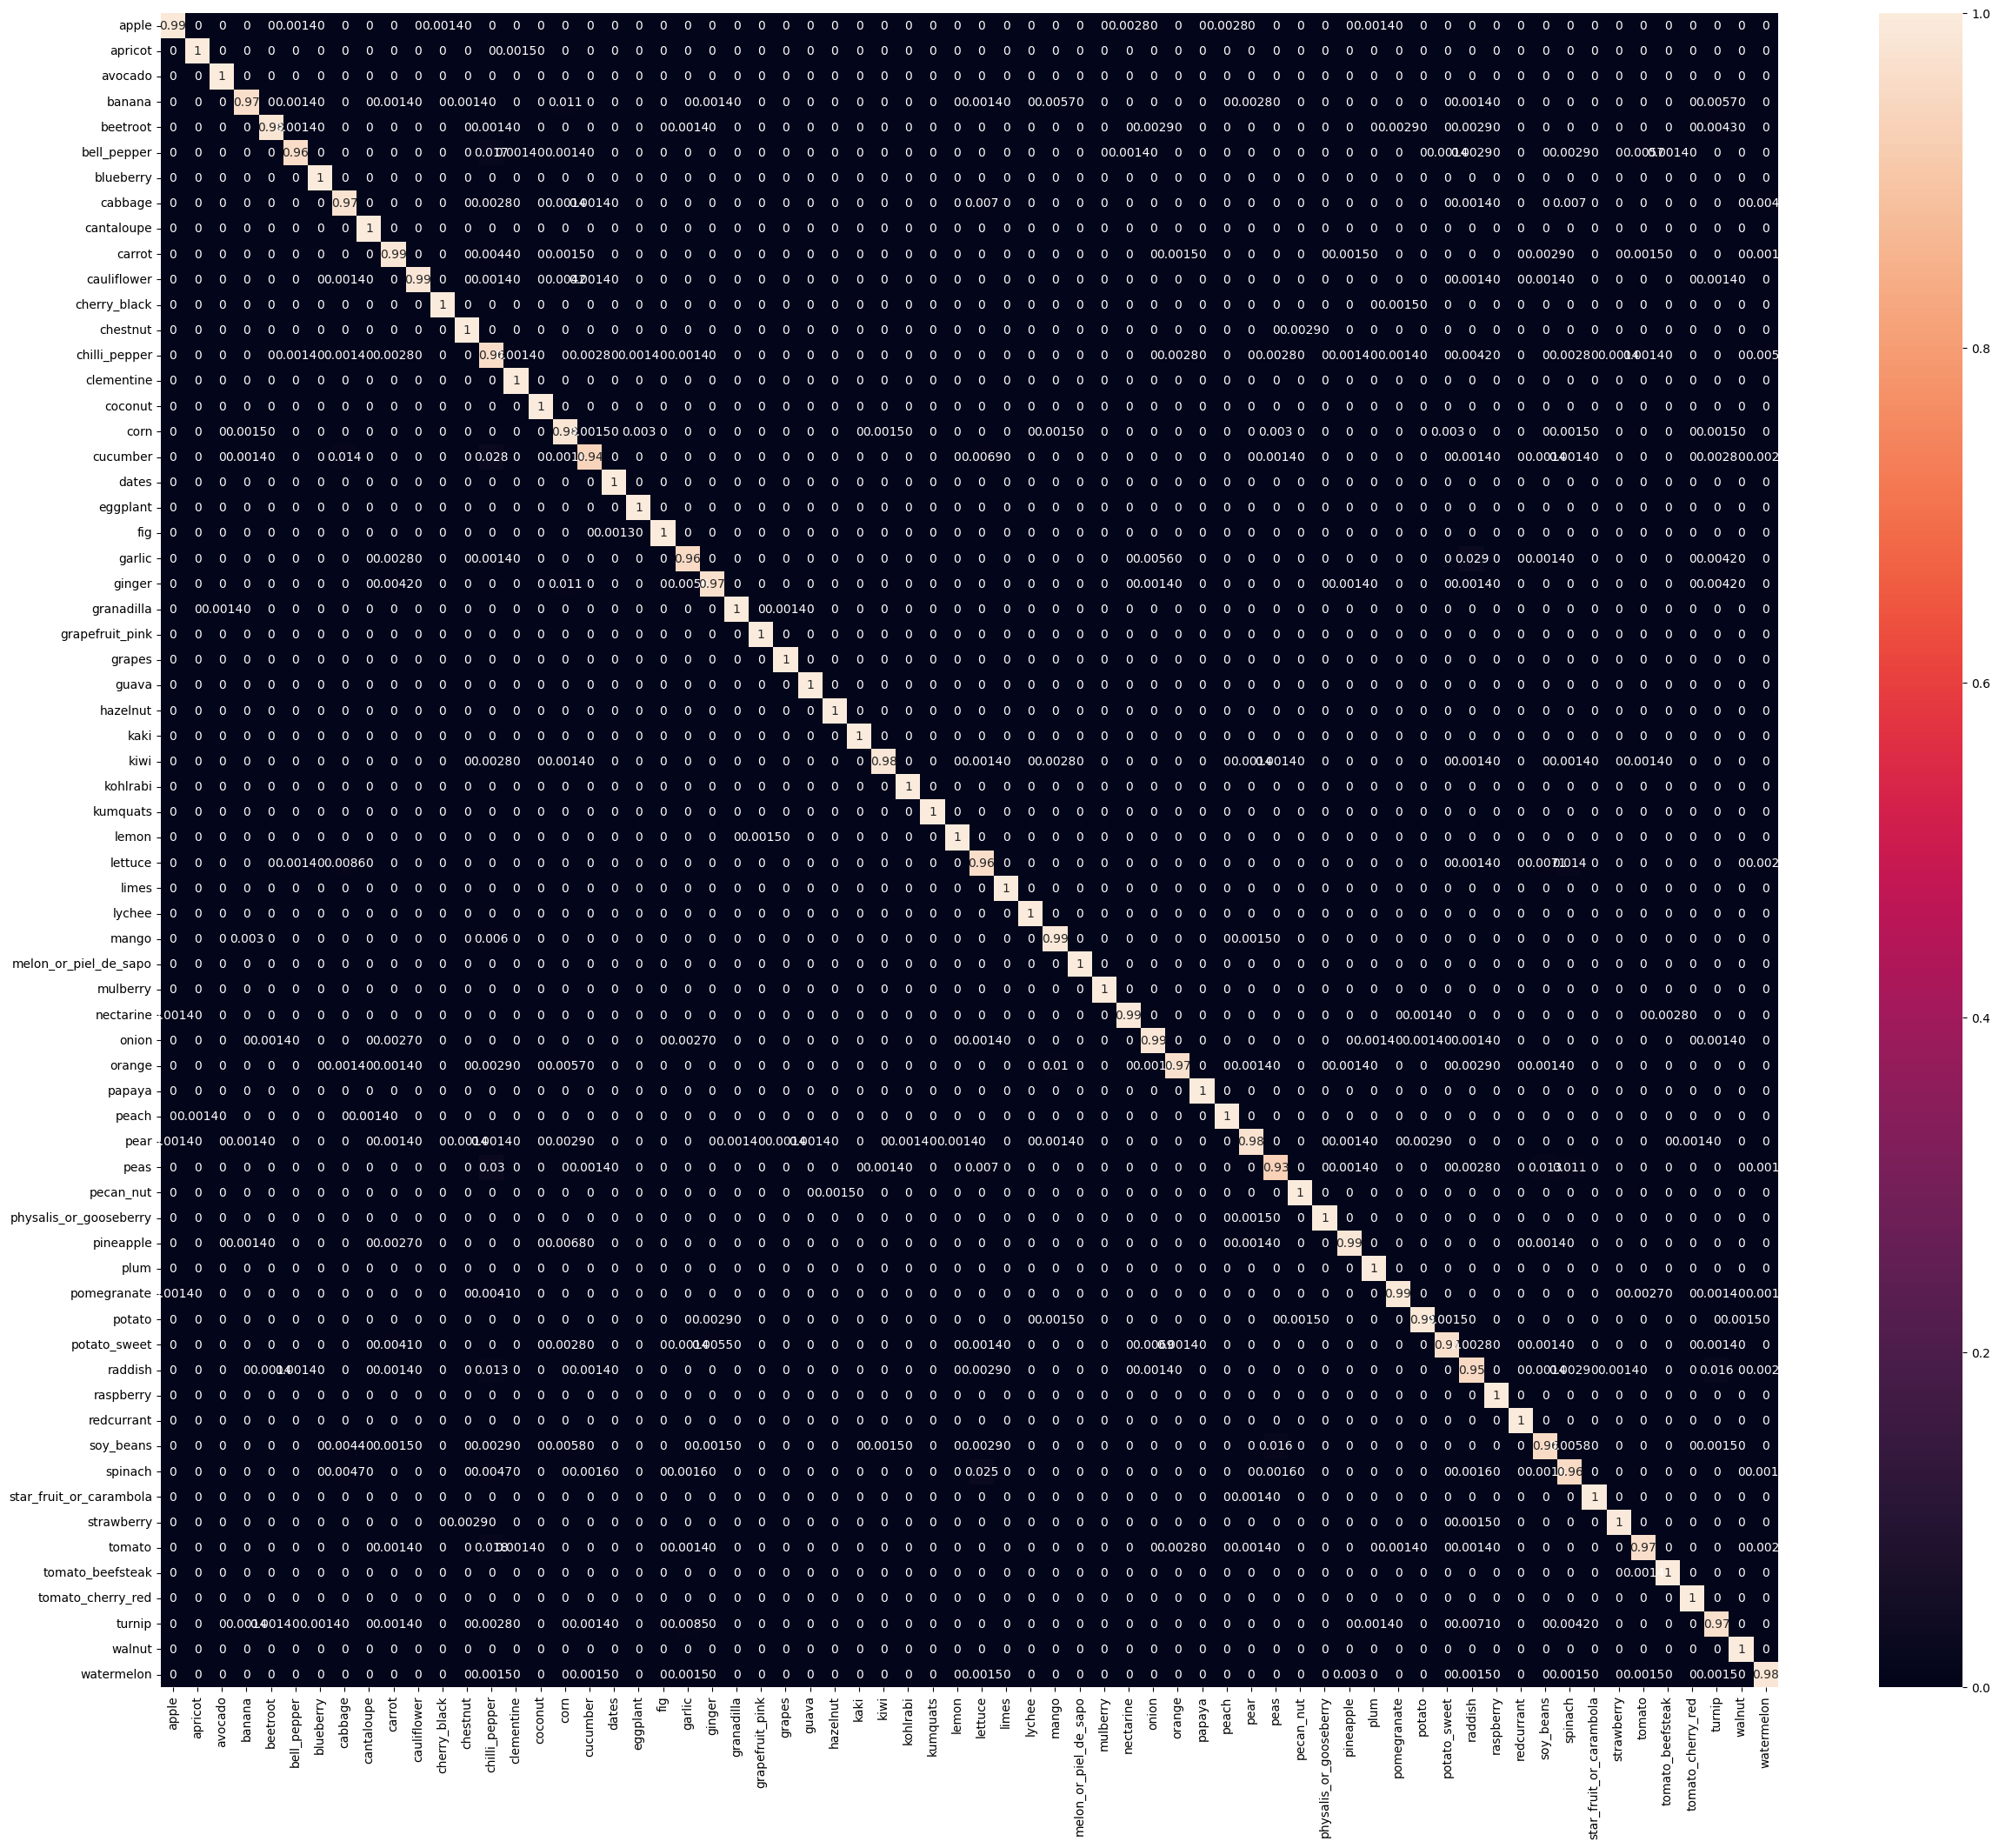

In [19]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


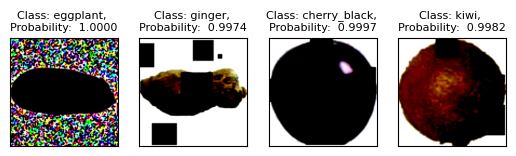

In [17]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


In [60]:
import os
path = "CV_data/own_photos/"
path = "CV_data/own_photos_no_background/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)

transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['mango', 'banana', 'apple', 'bell_pepper', 'strawberry', 'cucumber']


In [61]:
import cv2
import numpy as np

In [62]:
def extract_object(image_batch):
    processed_images = []
    for image in image_batch:
        image = np.clip(image, 0, 1)

        image = (image * 255).byte().numpy()
        image = np.transpose(image, (1, 2, 0))

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        thresh = thresh.astype(np.uint8)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            max_contour = max(contours, key=cv2.contourArea)

            x, y, w, h = cv2.boundingRect(max_contour)

            max_size = max(w, h)
            if w % 2 == 1:
                w = w - 1
            if h % 2 == 1:
                h = h - 1

            if w < h:
                x0_new = int(x+w/2-h/2)
                x1_new = int(x+w/2+h/2)
                if x0_new < 0:
                    x1_new -= x0_new
                    x0_new = 0
                elif x1_new > RESOLUTION:
                    x0_new -= (x1_new - RESOLUTION)
                    x1_new = RESOLUTION
                image = image[y:y+h, x0_new:x1_new]
            elif w == h:
                image = image[y:y+h, x:x+w]
            else:
                y0_new = int(y+h/2-w/2)
                y1_new = int(y+h/2+w/2)
                if y0_new < 0:
                    y1_new -= y0_new
                    y0_new = 0
                elif y1_new > RESOLUTION:
                    y0_new -= (y1_new - RESOLUTION)
                    y1_new = RESOLUTION
                image = image[y0_new:y1_new, x:x+w]

            image = np.transpose(image, (2, 0, 1))

            image = torch.from_numpy(image)
            transform = transforms.Resize(RESOLUTION)
            image = transform(image)

            processed_images.append(image)
        else:
            image = np.transpose(image, (2, 0, 1))

            processed_images.append(image)

    processed_images = torch.stack(processed_images).float() / 255.0

    return processed_images

{'class': 'strawberry', 'proba': 0.69831365}
{'class': 'kaki', 'proba': 0.041018497}
{'class': 'granadilla', 'proba': 0.03540797}
{'class': 'apple', 'proba': 0.028117077}
{'class': 'cucumber', 'proba': 0.023765938}


{'class': 'apple', 'proba': 0.30756623}
{'class': 'strawberry', 'proba': 0.11300097}
{'class': 'chilli_pepper', 'proba': 0.08557685}
{'class': 'pecan_nut', 'proba': 0.06269299}
{'class': 'raddish', 'proba': 0.056767352}


{'class': 'grapes', 'proba': 0.98985285}
{'class': 'chilli_pepper', 'proba': 0.0016146456}
{'class': 'cucumber', 'proba': 0.00092956494}
{'class': 'apple', 'proba': 0.00087378203}
{'class': 'cabbage', 'proba': 0.000861631}


{'class': 'avocado', 'proba': 0.70162594}
{'class': 'chilli_pepper', 'proba': 0.05483213}
{'class': 'cucumber', 'proba': 0.04685325}
{'class': 'mango', 'proba': 0.033233423}
{'class': 'raddish', 'proba': 0.023609301}


{'class': 'avocado', 'proba': 0.14060523}
{'class': 'beetroot', 'proba': 0.13129304}
{'class': 'lettuce', 'proba': 0.

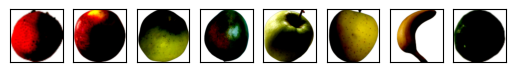

In [64]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):
    features = features
    targets = targets
    break

features = extract_object(features)

NUM_IMG = 8
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    proba_indices = np.argsort(probas[0])[::-1][:5]  # Get indices of top 5 classes
    top_classes = [{"class": idx_to_class[idx], "proba": probas[0][idx]} for idx in proba_indices]
    classes.extend(top_classes)

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        if imgs[i].dtype == torch.float32 or imgs[i].dtype == torch.float64:
            imgs[i] = np.clip(imgs[i], 0, 1)
        ax.imshow(imgs[i])
    ax.set_xticks([])
    ax.set_yticks([])

for i, c in enumerate(classes):
    print(c)
    if ((i + 1) % 5) == 0:
        print('\n')

In [57]:
# Checking the dataset
for images, labels in custom_test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break

Image batch dimensions: torch.Size([29, 3, 200, 200])
Image label dimensions: torch.Size([29])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        4, 4, 5, 5, 5])


In [25]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Vegetables', 'Food Name': 'Cucumber w skin raw', 'Energy(kcal)': 13, 'Water(g)': '96,7', 'Protein(g)': '0,7', 'Fat(g)': '0,4', 'Fatty_acids_total(g)': '0,3', 'Fatty acids saturated total(g)': '0,1', 'Carbohydrate(g)': '1,3', 'Sugar(g)': '1,3', 'Starch(g)': '0', 'Fiber dietary total(g)': '0,6', 'Na(mg)': 2.0, 'K(mg)': 187.0, 'Ca(mg)': 20.0, 'P(mg)': 32.0, 'Mg(mg)': 11.0, 'Fe(mg)': '1,1', 'Cu(mg)': '0,03', 'Se(µg)': 0.0, 'Zn(mg)': '0,63', 'Id(µg)': '3', 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': '0,1', 'Vitamin_K(µg)': '20,9', 'Vitamin_B1(mg)': '0,01', 'Vitamin_B2(mg)': '0,02', 'Vitamin_B6(mg)': '0,034', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '0,2', 'Vitamin_C(mg)': 4.0, 'Vitamin_A': 447.0}
{
    "Food Name": "Cucumber w skin raw",
    "Energy(kcal)": 13,
    "Water(g)": 96.7,
    "Protein(g)": 0.7,
    "Fat(g)": 0.4,
    "Fatty_acids_total(g)": 0.3,
    "Fatty acids saturated total(g)": 0.1,
    "Carbohydrate(g)": 1.3,
    "Sugar(g)": 1.3,
    "Fiber dietary total(g)": 0.